In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from skidl.pyspice import *
print(lib_search_paths)

{'kicad': ['.'], 'skidl': ['.', '/usr/local/lib/python3.6/site-packages/skidl/libs'], 'spice': ['.']}


100.0 258.238916125081 -1.5717969083591377 322.6984254295311



No errors or warnings found during netlist generation.



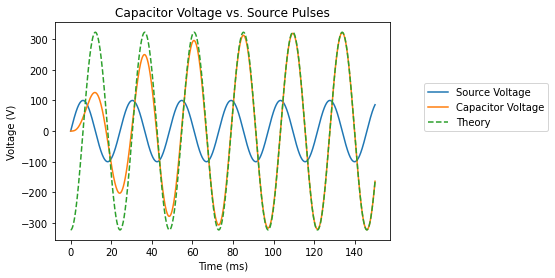

In [4]:
reset()  # Clear out the existing circuitry from the previous example.

frequency = 41.1
omega = 2.0*np.pi*frequency
#omega = np.sqrt(float(1.0/(l.value*c.value)))+1
#frequency = omega/(2.0*np.pi)
amplitude = 100.0
end_time = 150.0
step_time = 0.01

# Create a sinusoidal voltage source, a resistor, and a capacitor.
vs = SINEV(amplitude=amplitude@u_V, frequency=frequency@u_Hz)  # 100V sine wave source at 100 Hz.

r = R(value=0.012@u_kOhm)    # 12 ohm resistor.
c = C(value=100@u_uF)        # 100 uF capacitor.
l = L(value=.15@u_H)        # 0.15 H inductor
r['+', '-'] += vs['p'], l['+']  # Connect the resistor between the positive source terminal and one of the inductor terminals.
c['+'] += l['-']                # Connect one terminal of the capacitor to the other inductor terminal.
gnd += vs['n'], c['-']          # Connect the negative battery terminal and the other capacitor terminal to ground.

# Simulate the circuit.
circ = generate_netlist()            # Create the PySpice Circuit object from the SKiDL code.
sim = circ.simulator()               # Get a simulator for the Circuit object.
waveforms = sim.transient(step_time=step_time@u_ms, end_time=end_time@u_ms)  # Run a transient simulation from 0 to 150 msec.

# Get the simulation data.
time = waveforms.time                  # Time values for each point on the waveforms.
pulses = waveforms[node(vs['p'])]      # Voltage on the positive terminal of the pulsed voltage source.
cap_voltage = waveforms[node(c['+'])]  # Voltage on the capacitor.

# Theory
if (float(1.0-omega**2*l.value*c.value)) == 0:
    phase = 0.0
else:
    argument = float(-1.0*omega*r.value*c.value/(1.0-omega**2*l.value*c.value))
    phase = np.arctan(argument)
    if (phase>0):
        phase = phase-np.pi
tt = np.arange(0.0,end_time/1000.0,step_time/1000.0)
camplitude = amplitude/np.sqrt((1.0-float(omega**2*l.value*c.value))**2 + float(omega*r.value*c.value)**2)
cap_voltage_theory = camplitude*np.sin(omega*tt+phase)
print (amplitude,omega,phase,camplitude)

# Plot the pulsed source and capacitor voltage values versus time.
figure = plt.figure(1)
plt.title('Capacitor Voltage vs. Source Pulses')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.plot(time*1000, pulses)       # Plot pulsed source waveform.
plt.plot(time*1000, cap_voltage)  # Plot capacitor charging waveform.
plt.plot(tt*1000,cap_voltage_theory,'--')
plt.legend(('Source Voltage', 'Capacitor Voltage','Theory'), loc=(1.1, 0.5))
plt.show()